In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [3]:
CLASSES = 2
REGRESSIONS = 8

In [4]:
tf.enable_eager_execution()

In [5]:
def read_data(serialized_example):
    features = tf.parse_single_example(
            serialized=serialized_example,
            features={
                'img_name': tf.FixedLenFeature([], tf.string),
                'img_height': tf.FixedLenFeature([], tf.int64),
                'img_width': tf.FixedLenFeature([], tf.int64),
                'img': tf.FixedLenFeature([], tf.string),
                'gtboxes_and_label': tf.FixedLenFeature([], tf.string),
                'num_objects': tf.FixedLenFeature([], tf.int64)
            }
        )
    img_name = features['img_name']
    img_height = tf.cast(features['img_height'], tf.int32)
    img_width = tf.cast(features['img_width'], tf.int32)
    img = tf.decode_raw(features['img'], tf.uint8)
    
    img = tf.reshape(img, shape=[img_height, img_width, 3])
    
    gtboxes_and_label = tf.decode_raw(features['gtboxes_and_label'], tf.int32)
    gtboxes_and_label = tf.reshape(gtboxes_and_label, [-1, 9])
    
    num_objects = tf.cast(features['num_objects'], tf.int32)
    return img, gtboxes_and_label

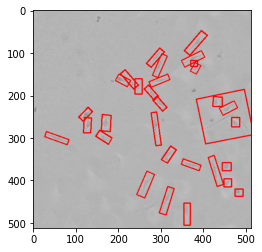

In [8]:
tfrecords_path = '/datasets/tfrecord/UFRGS_CELL_train'
dataset = tf.data.TFRecordDataset(tf.io.gfile.glob(tfrecords_path+'*.tfrecord'))
dataset = dataset.map(read_data)
#dataset = dataset.map(adjust_data)
#dataset = dataset.batch(1)
#dataset = dataset.repeat()

for sample in dataset.take(12):
    pass

draw = np.copy(sample[0])
label = [lb[:-1].reshape(-1,2) for lb in sample[1].numpy()]

cv2.drawContours(draw, label, -1, (255,0,0), 2)

plt.imshow(draw)

In [51]:
def get_gt(all_centers, reduce=16):
    """ TBD: add center displacement """
    
    final_gt = []
    
    # do all the flow for each possible class
    for cl in range(CLASSES):
        centers = all_centers[...,REGRESSIONS+cl]
        
        # placeholder for placing the centers
        ground_truth = np.zeros(shape=(centers.shape[0]//reduce,centers.shape[1]//reduce,REGRESSIONS))
        
        # first map all unique center points and save the conflits
        conflits = []
        for gh,h in enumerate(range(reduce//2,centers.shape[0]-reduce//2,reduce)):
            for gw,w in enumerate(range(reduce//2,centers.shape[1]-reduce//2,reduce)):
                patch = centers[h-reduce//2:h+reduce//2, w-reduce//2:w+reduce//2]

                # get the number of center points
                nbr_centers = np.count_nonzero(patch)

                if nbr_centers==1:
                    regression = all_centers[h-reduce//2:h+reduce//2, w-reduce//2:w+reduce//2,:-CLASSES]
                    ground_truth[gh,gw] = np.sum(regression, axis=(0,1))

                if nbr_centers>1:
                    conflits.append([[gh,gw], [h,w]])
        
        # iterate over patches with conflits
        for (gh,gw), (h,w) in conflits:
            # get the conflit points in the patch
            patch = centers[h-reduce//2:h+reduce//2, w-reduce//2:w+reduce//2]
            regression = all_centers[h-reduce//2:h+reduce//2, w-reduce//2:w+reduce//2,:-CLASSES]
            
            # get point of label
            cnt_pts = np.where(patch>0)
            cnt_pts = [[cnt_pts[0][i],cnt_pts[1][i]] for i in range(len(cnt_pts))]

            # calculate the distance to the borders
            dleft, dright, dtop, dbottom = [],[],[],[]
            for pt in cnt_pts:
                dleft.append(pt[1])
                dright.append(ground_truth.shape[0]-pt[0])
                dtop.append(pt[0])
                dbottom.append(ground_truth.shape[1]-pt[1])

            # calculate the distance to the center and sort related to how close they are to the center
            cnt_dist = [np.square((p[0]-reduce/2.)**2. + (p[1]-reduce/2.)**2.) for p in cnt_pts]
            arg_pts = np.argsort(cnt_dist, kind='mergesort')
            
            # get the regression values
            regression = [regression[pt[0],pt[1]] for p in cnt_pts]

            # now fill the gaps related to the conflits
            for i in arg_pts:
                # verify the best displacement
                extreme = np.array([dleft[i], dright[i], dtop[i], dbottom[i]])
                extreme = np.argsort(extreme, kind='mergesort')
                found = False

                # try to fit in the sorted best direction
                found = False
                for k in range(ground_truth.shape[0]):
                    for disp in extreme:
                        if disp==0: # left
                            if np.sum(ground_truth[gh, gw-k])==0 and gw-k>0:
                                ground_truth[gh, gw-k] = regression[i]
                                found = True
                        elif disp==1: # right
                            if gw+k<ground_truth.shape[1] and np.sum(ground_truth[gh, gw+k])==0:
                                ground_truth[gh, gw+k] = regression[i]
                                found = True
                        elif disp==2: # top
                            if np.sum(ground_truth[gh-k, gw])==0 and gh-k>0:
                                ground_truth[gh-k, gw] = regression[i]
                                found = True
                        else: # bottom
                            if gh+k<ground_truth.shape[0] and np.sum(ground_truth[gh+k, gw])==0:
                                ground_truth[gh+k, gw] = regression[i]
                                found = True
                        if found:
                            break
                    if found:
                        break
                        
        final_gt.append(ground_truth)
                    
    return np.stack(final_gt, axis=-1).astype('float32')

In [52]:
def adjust_data(img, labels):
    # norm image
    img = tf.cast(img, 'float32')/127.5 - 1
    
    # get the center
    centers = np.zeros(shape=(*img.shape[:2],REGRESSIONS+CLASSES), dtype='int32')
    for lb in labels:
        box = lb[:-1].reshape(-1,2)
        cx = int(np.mean(box[:,0]))
        cy = int(np.mean(box[:,1]))
        
        if np.sum(centers[cy,cx])>1:
            raise Exception()
        centers[cy,cx,-1-lb[-1]] = 1
        centers[cy,cx,:-CLASSES] = box.reshape(-1)
        
    return img, get_gt(centers)

In [50]:
img, centers = adjust_data(sample[0].numpy(), sample[1].numpy())

In [43]:
sample[1].shape

TensorShape([Dimension(31), Dimension(9)])

In [38]:
img.dtype

tf.float32

In [39]:
centers.dtype

dtype('float32')

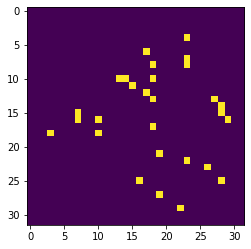

In [16]:
plt.imshow(np.clip(np.sum(gt[...,1], axis=-1), 0, 1))

In [56]:
@tf.function(input_signature=[tf.TensorSpec((None,None,3), tf.uint8), tf.TensorSpec((None,9), tf.int32)])
def tf_adjust_data(img, label):
    return tf.py_func(adjust_data, [img, label], [tf.float32, tf.float32])

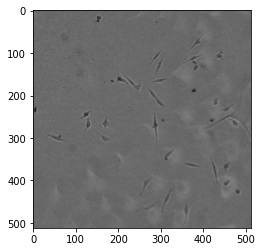

In [60]:
dataset = tf.data.TFRecordDataset(tf.io.gfile.glob(tfrecords_path+'*.tfrecord'))
dataset = dataset.map(read_data)
dataset = dataset.map(tf_adjust_data)
dataset = dataset.batch(1)
dataset = dataset.repeat()

for sample in dataset.take(12):
    pass

draw = np.copy(sample[0])
label = [lb[:-1].reshape(-1,2) for lb in sample[1].numpy()]

#cv2.drawContours(draw, label, -1, (255,0,0), 2)

plt.imshow(draw[0])

In [62]:
draw[0].min(), draw[0].max()

(0.05098045, 0.7019608)

In [63]:
len(sample)

2

In [64]:
sample[1].shape

TensorShape([Dimension(1), Dimension(32), Dimension(32), Dimension(8), Dimension(2)])